Source: https://thecleverprogrammer.com/2020/09/02/predict-fuel-efficiency-with-machine-learning/?source=post_page-----a4f142bc10c--------------------------------

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import numpy as np

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [25]:
column_names = ['MPG','Cylinders','Displacement','Horsepower','Weight',
                'Acceleration', 'Model Year', 'Origin'] 
dataset = pd.read_csv("auto-mpg.csv", names=column_names,
                      na_values = "?", comment='\t',
                      sep=",", skipinitialspace=True, skiprows=[0], index_col=False)
dataset

C:\Users\Jui\AppData\Local\Temp\ipykernel_24784\1045237028.py:3: ParserWarning: Length of header or names does not match length of data. This leads to a loss of data with index_col=False.
  dataset = pd.read_csv("auto-mpg.csv", names=column_names,


,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Origin
0,18.0,8,307.0,130.0,3504,12.0,70,1
1,15.0,8,350.0,165.0,3693,11.5,70,1
2,18.0,8,318.0,150.0,3436,11.0,70,1
3,16.0,8,304.0,150.0,3433,12.0,70,1
4,17.0,8,302.0,140.0,3449,10.5,70,1
...,...,...,...,...,...,...,...,...
393,27.0,4,140.0,86.0,2790,15.6,82,1
394,44.0,4,97.0,52.0,2130,24.6,82,2
395,32.0,4,135.0,84.0,2295,11.6,82,1
396,28.0,4,120.0,79.0,2625,18.6,82,1


In [26]:
origin = dataset.pop('Origin')
dataset['USA'] = (origin == 1)*1.0
dataset['Europe'] = (origin == 2)*1.0
dataset['Japan'] = (origin == 3)*1.0

In [27]:
train_dataset = dataset.sample(frac=0.8,random_state=0)
test_dataset = dataset.drop(train_dataset.index)

# Check for duplicate column names
print(train_dataset.columns[train_dataset.columns.duplicated()])

print(len(train_dataset))
print(len(test_dataset))

Index([], dtype='object')
318
80


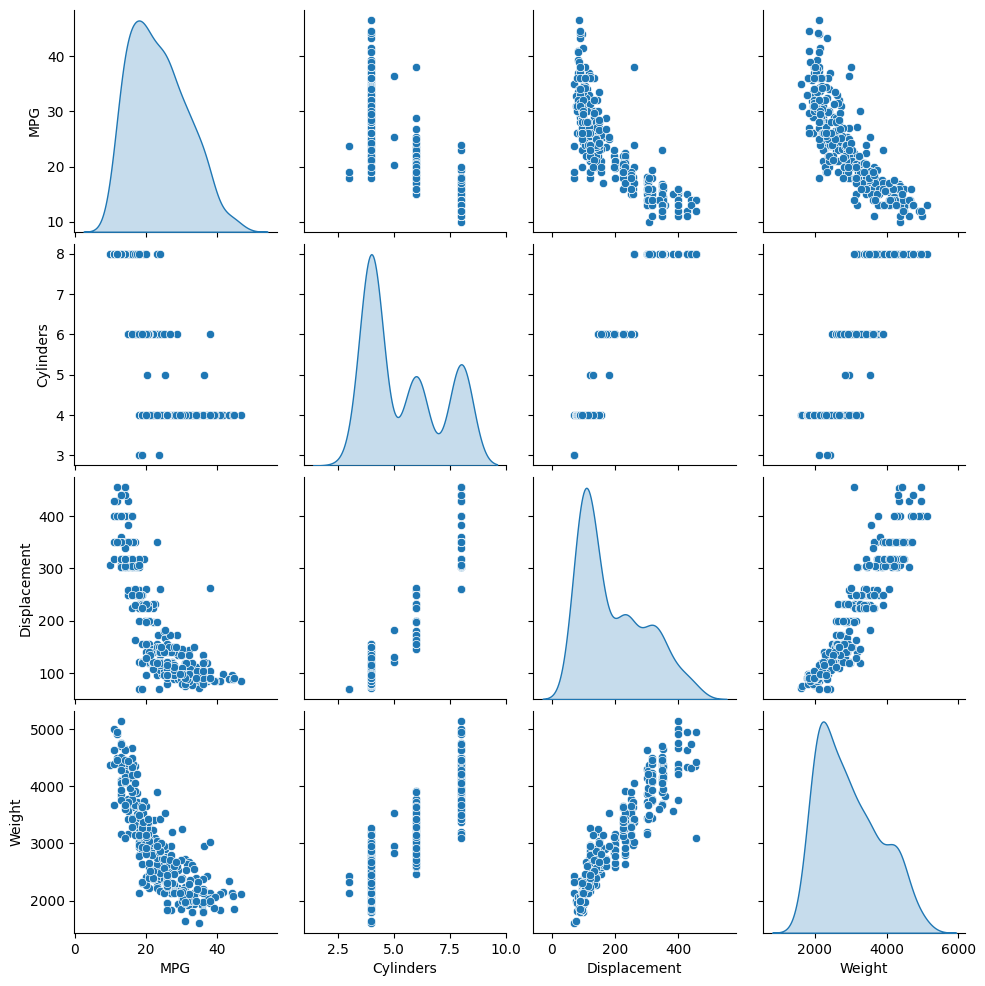

In [28]:
sns.pairplot(train_dataset[["MPG", "Cylinders", "Displacement", "Weight"]], diag_kind="kde")

In [29]:
train_labels = train_dataset.pop('MPG')
print(train_labels)
test_labels = test_dataset.pop('MPG')
train_stats = train_dataset.describe().transpose()

65     14.0
132    25.0
74     13.0
78     21.0
37     18.0
       ... 
207    20.0
279    29.5
227    19.0
148    26.0
143    26.0
Name: MPG, Length: 318, dtype: float64


In [30]:
def norm(x):
  return (x - train_stats['mean']) / train_stats['std']
normed_train_data = norm(train_dataset)
normed_test_data = norm(test_dataset)

In [39]:
print("Checking for NaN values in normed_train_data:", np.isnan(normed_train_data).sum().sum())
print("Checking for Infinite values in normed_train_data:", np.isinf(normed_train_data).sum().sum())
print("Checking for NaN values in train_labels:", np.isnan(train_labels).sum())
print("Checking for Infinite values in train_labels:", np.isinf(train_labels).sum())

Checking for NaN values in normed_train_data: 5
Checking for Infinite values in normed_train_data: 0
Checking for NaN values in train_labels: 0
Checking for Infinite values in train_labels: 0


In [40]:
print("First few rows of normed_train_data:\n", normed_train_data.head())

First few rows of normed_train_data:
      Cylinders  Displacement  Horsepower    Weight  Acceleration  Model Year  \
65    1.528471      1.521380    1.265245  1.379315     -0.928344   -1.065117   
132  -0.848320     -0.511125   -0.751580 -0.499348      0.502127   -0.525344   
74    1.528471      1.049377    0.929107  1.574639      0.144509   -1.065117   
78   -0.848320     -0.703780   -0.441299  0.017965      1.396171   -1.065117   
37    0.340075      0.375086   -0.105162  0.383754     -0.034300   -1.335003   

          USA    Europe     Japan  
65   0.746369 -0.441445 -0.491351  
132  0.746369 -0.441445 -0.491351  
74   0.746369 -0.441445 -0.491351  
78  -1.335607  2.258163 -0.491351  
37   0.746369 -0.441445 -0.491351  


In [42]:
# Concatenate normed_train_data and train_labels to filter together
combined_train_data = pd.concat([normed_train_data, train_labels], axis=1)

# Drop rows with NaN values
cleaned_train_data = combined_train_data.dropna()

# Separate the cleaned data back into features and labels
normed_train_data = cleaned_train_data.iloc[:, :-1]  # all columns except the last one
train_labels = cleaned_train_data.iloc[:, -1]        # only the last column

In [43]:
print("Checking for NaN values in normed_train_data after cleaning:", np.isnan(normed_train_data).sum().sum())
print("Checking for Infinite values in normed_train_data after cleaning:", np.isinf(normed_train_data).sum().sum())
print("Checking for NaN values in train_labels after cleaning:", np.isnan(train_labels).sum())
print("Checking for Infinite values in train_labels after cleaning:", np.isinf(train_labels).sum())

Checking for NaN values in normed_train_data after cleaning: 0
Checking for Infinite values in normed_train_data after cleaning: 0
Checking for NaN values in train_labels after cleaning: 0
Checking for Infinite values in train_labels after cleaning: 0


In [52]:
# Combine normed_test_data and test_labels
combined_test_data = pd.concat([normed_test_data, test_labels], axis=1)

# Drop rows with NaN values
cleaned_test_data = combined_test_data.dropna()

# Separate the cleaned data back into features and labels
normed_test_data = cleaned_test_data.iloc[:, :-1]  # all columns except the last one
test_labels = cleaned_test_data.iloc[:, -1]        # only the last column

print("Checking for NaN values in normed_test_data after cleaning:", np.isnan(normed_test_data).sum().sum())
print("Checking for Infinite values in normed_test_data after cleaning:", np.isinf(normed_test_data).sum().sum())
print("Checking for NaN values in test_labels after cleaning:", np.isnan(test_labels).sum())
print("Checking for Infinite values in test_labels after cleaning:", np.isinf(test_labels).sum())

Checking for NaN values in normed_test_data after cleaning: 0
Checking for Infinite values in normed_test_data after cleaning: 0
Checking for NaN values in test_labels after cleaning: 0
Checking for Infinite values in test_labels after cleaning: 0


In [44]:
def build_model():
  model = keras.Sequential([
    layers.Dense(64, activation=tf.nn.relu, input_shape=[len(train_dataset.keys())]),
    layers.Dense(64, activation=tf.nn.relu),
    layers.Dense(1)
  ])

  optimizer = tf.keras.optimizers.RMSprop(0.001)

  model.compile(loss='mean_squared_error',
                optimizer=optimizer,
                metrics=['mean_absolute_error', 'mean_squared_error'])
  return model
model = build_model()
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_9 (Dense)             (None, 64)                640       
                                                                 
 dense_10 (Dense)            (None, 64)                4160      
                                                                 
 dense_11 (Dense)            (None, 1)                 65        
                                                                 
Total params: 4865 (19.00 KB)
Trainable params: 4865 (19.00 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [45]:
example_batch = normed_train_data[:10]
# print(example_batch)
example_result = model.predict(example_batch)
example_result

1/1 [==============================] - 0s 47ms/step


array([[ 0.34811735],
       [-0.15275276],
       [ 0.08771536],
       [-0.17762296],
       [-0.05624651],
       [-0.53738075],
       [-0.63719463],
       [-0.17014775],
       [ 0.1699574 ],
       [-0.1983793 ]], dtype=float32)

In [46]:
class PrintDot(keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs):
    if epoch % 100 == 0: print('')
    print('.', end='')

EPOCHS = 1000

history = model.fit(
  normed_train_data, train_labels,
  epochs=EPOCHS, validation_split = 0.2, verbose=0,
  callbacks=[PrintDot()])


....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
..........................................................................................

In [47]:
print("History keys:", history.history.keys())
print("First few rows of history:\n", pd.DataFrame(history.history).head())

History keys: dict_keys(['loss', 'mean_absolute_error', 'mean_squared_error', 'val_loss', 'val_mean_absolute_error', 'val_mean_squared_error'])
First few rows of history:
          loss  mean_absolute_error  mean_squared_error    val_loss  \
0  595.823669            22.944977          595.823669  566.324402   
1  542.666870            21.717194          542.666870  518.915405   
2  492.183075            20.493336          492.183075  470.433990   
3  438.525024            19.158804          438.525024  416.828369   
4  379.353149            17.583263          379.353149  357.457275   

   val_mean_absolute_error  val_mean_squared_error  
0                22.444839              566.324402  
1                21.334274              518.915405  
2                20.140331              470.433990  
3                18.761757              416.828369  
4                17.197191              357.457275  


           loss  mean_absolute_error  mean_squared_error    val_loss  \
0    595.823669            22.944977          595.823669  566.324402   
1    542.666870            21.717194          542.666870  518.915405   
2    492.183075            20.493336          492.183075  470.433990   
3    438.525024            19.158804          438.525024  416.828369   
4    379.353149            17.583263          379.353149  357.457275   
..          ...                  ...                 ...         ...   
995    2.664624             1.088094            2.664624    6.611114   
996    2.352160             0.993767            2.352160    6.391893   
997    2.471704             1.013658            2.471704    6.346384   
998    2.542090             1.029540            2.542090    6.756817   
999    2.537388             1.009689            2.537388    6.775424   

     val_mean_absolute_error  val_mean_squared_error  
0                  22.444839              566.324402  
1                  21.334

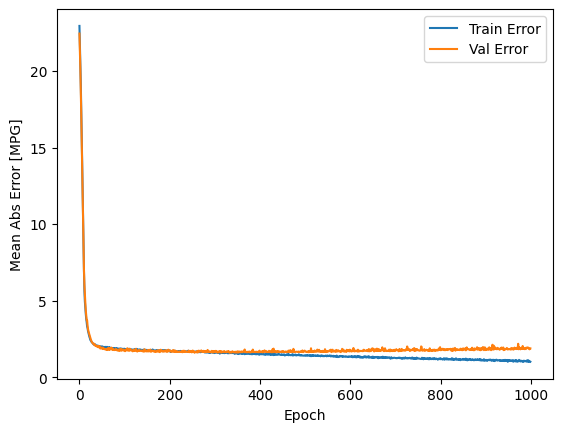

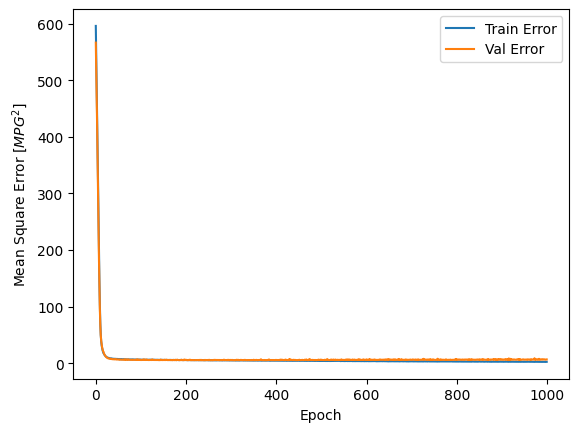

In [48]:
def plot_history(history):
  hist = pd.DataFrame(history.history)
  print(hist)
  hist['epoch'] = history.epoch
  
  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Mean Abs Error [MPG]')
  plt.plot(hist['epoch'], hist['mean_absolute_error'],
           label='Train Error')
  plt.plot(hist['epoch'], hist['val_mean_absolute_error'],
           label = 'Val Error')
#   plt.ylim([0,5])
  plt.legend()
  
  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Mean Square Error [$MPG^2$]')
  plt.plot(hist['epoch'], hist['mean_squared_error'],
           label='Train Error')
  plt.plot(hist['epoch'], hist['val_mean_squared_error'],
           label = 'Val Error')
#   plt.ylim([0,20])
  plt.legend()
  plt.show()
plot_history(history)


...............................................................................          loss  mean_absolute_error  mean_squared_error    val_loss  \
0   582.260986            22.720726          582.260986  554.611389   
1   531.090515            21.541451          531.090515  507.448547   
2   477.592072            20.288580          477.592072  452.795471   
3   418.070892            18.830246          418.070892  392.865204   
4   355.948517            17.172949          355.948517  332.892914   
..         ...                  ...                 ...         ...   
74    6.379978             1.864657            6.379978    5.942855   
75    6.354646             1.852353            6.354646    5.870800   
76    6.457497             1.835783            6.457497    5.998057   
77    6.309225             1.839514            6.309225    5.885046   
78    6.324421             1.807061            6.324421    5.829204   

    val_mean_absolute_error  val_mean_squared_error  
0            

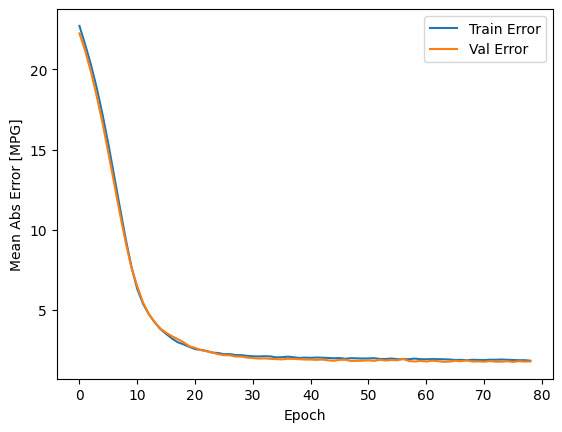

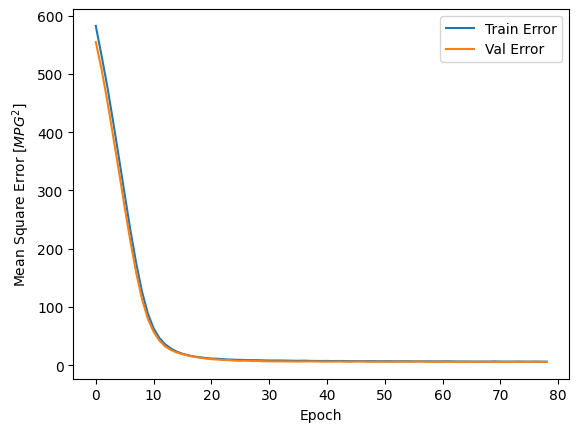

In [49]:
model = build_model()

# The patience parameter is the amount of epochs to check for improvement
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)

history = model.fit(normed_train_data, train_labels, epochs=EPOCHS,
                    validation_split = 0.2, verbose=0, callbacks=[early_stop, PrintDot()])

plot_history(history)

In [53]:
loss, mae, mse = model.evaluate(normed_test_data, test_labels, verbose=0)
print("Testing set Mean Abs Error: {:5.2f} MPG".format(mae))

Testing set Mean Abs Error:  1.94 MPG


3/3 [==============================] - 0s 7ms/step


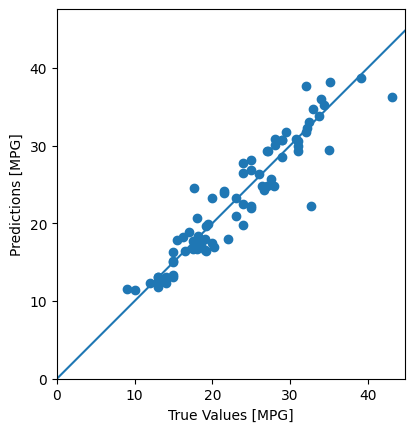

In [54]:
test_predictions = model.predict(normed_test_data).flatten()

plt.scatter(test_labels, test_predictions)
plt.xlabel('True Values [MPG]')
plt.ylabel('Predictions [MPG]')
plt.axis('equal')
plt.axis('square')
plt.xlim([0,plt.xlim()[1]])
plt.ylim([0,plt.ylim()[1]])
_ = plt.plot([-100, 100], [-100, 100])